<a href="https://colab.research.google.com/github/realtechsupport/cocktail/blob/main/sandbox/testing_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [1]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 39.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import rasterio
import keras
import tensorflow as tf

preprocessing the images

1.   normalize
2.   resize
3. patches
4. create numpyarray out of patches list



In [5]:

# Load the GeoTIFF file
with rasterio.open('/content/gdrive/MyDrive/exp/output.tif') as src:
    # Read the TIFF data
    tiff_data = src.read()

    # Get the shape of the TIFF data
    num_bands, height, width = tiff_data.shape

    print("Original image dimensions:", num_bands, height, width)

    print(np.min(tiff_data), np.max(tiff_data))


    normalized_image = np.zeros_like(tiff_data, dtype='float32')
    for band in range(tiff_data.shape[1]):
        band_min = np.min(tiff_data[:, band])
        band_max = np.max(tiff_data[:, band])
        normalized_image[:, band] = (tiff_data[:, band] - band_min) / (band_max - band_min)

    # Calculate the new width and height that are multiples of the patch size
    patch_size = 256  # Replace with your desired patch size
    new_width = int(np.floor(width / patch_size)) * patch_size
    new_height = int(np.floor(height / patch_size)) * patch_size

    print("cropped dimensions:", new_height, new_width)

    input_image = np.moveaxis(normalized_image, 0, -1)

    # Crop the input_image to the new dimensions
    cropped_array = input_image[:new_height, :new_width, :]

print("Cropped array shape:", cropped_array.shape)
print(np.min(cropped_array), np.max(cropped_array))

Original image dimensions: 8 4096 4864
1.0 10610.0
cropped dimensions: 4096 4864
Cropped array shape: (4096, 4864, 8)
0.0 1.0


In [6]:
patches = []
for i in range(0, cropped_array.shape[0], patch_size):
    for j in range(0, cropped_array.shape[1], patch_size):
        patch = cropped_array[i:i+patch_size, j:j+patch_size]
        patches.append(patch)

In [7]:
training_images = np.array(patches)

preprocessing the masks:

1. resize, squeeze out extra dimension
2. create patches
3. one-hot encoding


In [8]:


with rasterio.open('/content/gdrive/MyDrive/exp/crop_mask.tif') as src:
    # Read the TIFF data
    output_mask = src.read()

    # Calculate the new width and height that are multiples of the patch size
    patch_size = 256  # Replace with your desired patch size
    new_width = int(np.floor(width / patch_size)) * patch_size
    new_height = int(np.floor(height / patch_size)) * patch_size

    print("cropped dimensions:", new_height, new_width)

    output_mask = np.moveaxis(output_mask, 0, -1)

    # Crop the input_image to the new dimensions
    cropped_mask = output_mask[:new_height, :new_width, :]

print("Cropped array shape:", cropped_mask.shape)

cropped dimensions: 4096 4864
Cropped array shape: (4096, 4864, 1)


In [9]:
new_mask = np.squeeze(cropped_mask)

In [10]:
masks = []
for i in range(0, new_mask.shape[0], patch_size):
    for j in range(0, new_mask.shape[1], patch_size):
        patch = new_mask[i:i+patch_size, j:j+patch_size]
        masks.append(patch)

In [11]:
from tensorflow.keras.utils import to_categorical
def onehotencoding(labels, num_classes=23):
    return to_categorical(labels, num_classes)

In [12]:
mask_array = np.array(masks)

Sampling:

In [ ]:
useful_images = []
useful_masks = []
useless = 0
indexes = []
for img in range(len(training_images)):
    img_name=training_images[img]
    mask_name = mask_array[img]

    val, counts = np.unique(mask_name, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.05:
      useful_images.append(img_name)
      useful_masks.append(mask_name)
      indexes.append(img)
      print("I am useful")

    else:
      print("I am useless")
      useless +=1

print("Total useful images are: ", len(training_images)-useless)
print("Total useless images are: ", useless)




In [14]:
useful_training_images = np.array(useful_images)
useful_training_masks_array = np.array(useful_masks)

In [15]:
useful_training_masks = onehotencoding(useful_training_masks_array)

Training:

1. model
2. training

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

# 5g
# def jacard_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# 5g
def multi_unet_model(n_classes=23, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=8): #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model




In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(useful_training_images,
                                                    useful_training_masks, test_size = 0.20, random_state = 42)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


metrics=['accuracy']


model = multi_unet_model(n_classes=23, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


model.compile(optimizer= tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    shuffle=False)

model.save('/content/gdrive/MyDrive/exp/model_1.hdf5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  1168        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

Model prediction

1. load the model
2. preprocess the image - normalization, resizing, patching
3. predict using the model
4. post process the patches - weighted argmax
5. stictch
6. display

In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/exp/model_1.hdf5', compile=False)

In [18]:
# Load the GeoTIFF file
with rasterio.open('/content/gdrive/MyDrive/exp/output.tif') as src:
    # Read the TIFF data
    tiff_data = src.read()

    # Get the shape of the TIFF data
    num_bands, height, width = tiff_data.shape

    print("Original image dimensions:", num_bands, height, width)

    print(np.min(tiff_data), np.max(tiff_data))


    normalized_image = np.zeros_like(tiff_data, dtype='float32')
    for band in range(tiff_data.shape[1]):
        band_min = np.min(tiff_data[:, band])
        band_max = np.max(tiff_data[:, band])
        normalized_image[:, band] = (tiff_data[:, band] - band_min) / (band_max - band_min)

    # Calculate the new width and height that are multiples of the patch size
    patch_size = 256  # Replace with your desired patch size
    new_width = int(np.floor(width / patch_size)) * patch_size
    new_height = int(np.floor(height / patch_size)) * patch_size

    print("cropped dimensions:", new_height, new_width)

    input_image = np.moveaxis(normalized_image, 0, -1)

    # Crop the input_image to the new dimensions
    cropped_array = input_image[:new_height, :new_width, :]

print("Cropped array shape:", cropped_array.shape)
print(np.min(cropped_array), np.max(cropped_array))

Original image dimensions: 8 4096 4864
1.0 10610.0
cropped dimensions: 4096 4864
Cropped array shape: (4096, 4864, 8)
0.0 1.0


In [19]:
patch_size = 256

In [20]:
patches = []
for i in range(0, cropped_array.shape[0], patch_size):
    for j in range(0, cropped_array.shape[1], patch_size):
        patch = cropped_array[i:i+patch_size, j:j+patch_size]
        patches.append(patch)

In [21]:
num_classes = 23  # Total number of classes including class 0

# Define the class weights (0 for class 0, equal weight for other classes)
class_weights = np.ones(num_classes)
class_weights[0] = 0  # Set weight 0 for class 0
class_weights /= np.sum(class_weights)  # Normalize to ensure sum equals 1



In [27]:
class_weights

array([0.        , 0.04545455, 0.04545455, 0.04545455, 0.04545455,
       0.04545455, 0.04545455, 0.04545455, 0.04545455, 0.04545455,
       0.04545455, 0.04545455, 0.04545455, 0.04545455, 0.04545455,
       0.04545455, 0.04545455, 0.04545455, 0.04545455, 0.04545455,
       0.04545455, 0.04545455, 0.04545455])

In [28]:
def predict_segmentation(patches):
    # Make predictions using the loaded model

    seg_patches = []
    for patch in patches:
        image = tf.expand_dims(patch, axis=0)
        prediction = model.predict(image)
        weighted_prediction = np.argmax(prediction * class_weights, axis=-1)
        seg_patches.append(weighted_prediction)

    return seg_patches

In [29]:
predicted_patches = predict_segmentation(patches)

1/1 [==============================] - 0s 184ms/step


In [34]:
np.unique(np.array(predicted_patches),return_counts = True)

(array([ 2,  6,  7, 11, 21]),
 array([  649857,   230845,      871, 15197268,  3844103]))

In [36]:


stitched_array = np.zeros((3840,4608), dtype=cropped_array.dtype)

In [37]:
stitched_array.shape

(3840, 4608)

In [38]:
patch_idx = 0
for i in range(0, 3840, 256):
    for j in range(0, 4608, 256):
        patch = predicted_patches[patch_idx]
        stitched_array[i:i+256, j:j+256] = patch
        patch_idx += 1

In [39]:
np.unique(stitched_array, return_counts= True)

(array([ 2.,  6.,  7., 11., 21.], dtype=float32),
 array([  586333,   207647,      772, 13468701,  3431267]))

1 5 5 230
2 190 60 15
3 65 240 125
4 105 200 95
5 30 115 10
6 255 196 34
7 110 85 5
8 235 235 220
9 120 216 47
10 84 142 128
11 84 142 128
12 84 142 128
13 50 255 215
14 50 255 215
15 50 255 215
16 193 255 0
17 105 200 95
18 105 200 95
19 105 200 95
20 193 255 0
21 255 50 185
22 255 255 255
23 0 0 0

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create an array with the given classes (replace this with your actual segmentation mask)
segmentation_mask = stitched_array

# Define the colormap with unique colors for each class
colors = [ (5, 5, 230),
          (190, 60, 15),

          (65, 240 ,125),     # Class 3 - shrub land
           (105, 200,95),
          (30, 115, 10),    # Class 5
           (255, 196, 34),
           (110, 85, 5),
          (235, 235, 220),    # Class 8
           (120, 216, 47),
           (84, 142, 128)
          (84, 142, 128),    # Class 11
           (84, 142, 128)
          (50 ,255 ,215),    # Class 13
          (50, 255, 215),    # Class 14
          (193, 255, 0)
          (255 50 185)]

cmap = ListedColormap(colors)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the segmentation mask using the custom colormap
image = ax.imshow(segmentation_mask, cmap=cmap, vmin=3., vmax=16.)

# Add a colorbar to show the class-color mapping
cbar = plt.colorbar(image, ax=ax, ticks=[3., 5., 8., 11., 13., 14., 16.])
cbar.set_label('Classes')

# Show the plot
plt.title('Segmentation Mask')
plt.show()


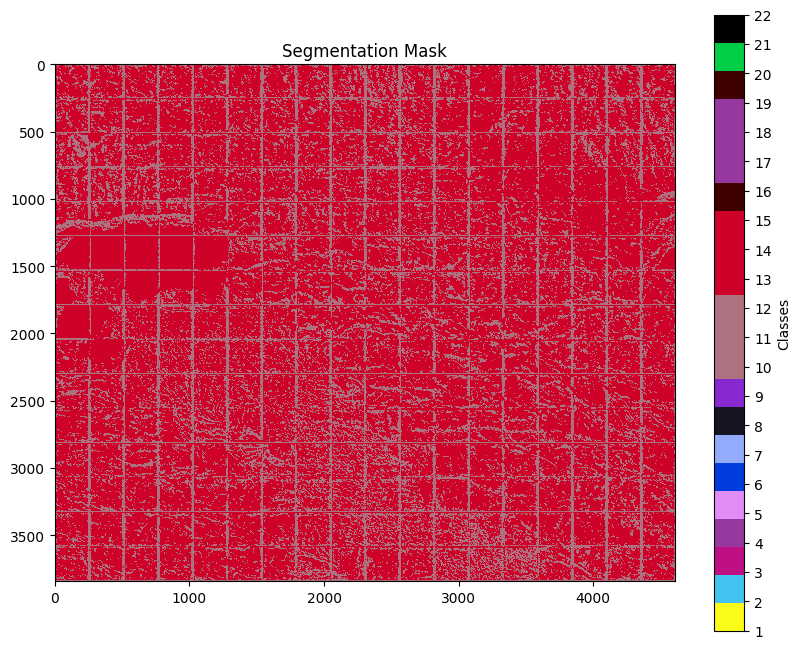

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create an array with class labels (example segmentation mask)
segmentation_mask = stitched_array  # Example labels

# Define the class-color mapping
class_colors = {
    1: ( 5, 5, 230),
    2: (190, 60, 15),
    3: (65, 240, 125),
    4: (105, 200, 95),
    5: ( 30, 115, 10),
    6: ( 255, 196, 34),
    7: (110, 85, 5),
    8: ( 235, 235, 220),
    9: (120, 216, 47),
    10: ( 84, 142, 128),
    11: ( 84, 142, 128),
    12: ( 84, 142, 128),
    13: ( 50, 255, 215),
    14: ( 50, 255, 215),
    15: ( 50, 255, 215),
    16: ( 193, 255, 0),
    17: ( 105, 200, 95),
    18: (105, 200, 95),
    19: ( 105, 200, 95),
    20: (193, 255, 0),
    21: ( 255, 50, 185),
    22: (255, 255, 255),
}

# Create a colormap using the class-color mapping
colors = [class_colors[i] for i in range(1, 23)]
cmap = ListedColormap(colors)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the segmentation mask using the custom colormap
image = ax.imshow(segmentation_mask, cmap=cmap, vmin=1, vmax=22)

# Add a colorbar to show the class-color mapping
cbar = plt.colorbar(image, ax=ax, ticks=list(class_colors.keys()))
cbar.set_label('Classes')

# Show the plot
plt.title('Segmentation Mask')
plt.show()
